**M1. Actividad Emiliano García Aguirre A00827638**

Dado:

Habitación de MxN espacios.
Número de agentes.
Porcentaje de celdas inicialmente sucias.
Tiempo máximo de ejecución.
Realiza la siguiente simulación:

Inicializa las celdas sucias (ubicaciones aleatorias).
Todos los agentes empiezan en la celda [1,1].
En cada paso de tiempo:
Si la celda está sucia, entonces aspira.
Si la celda está limpia, el agente elije una dirección aleatoria para moverse (unas de las 8 celdas vecinas) y elije la acción de movimiento (si no puede moverse allí, permanecerá en la misma celda).
Se ejecuta el tiempo máximo establecido.
Deberás recopilar la siguiente información durante la ejecución:

Tiempo necesario hasta que todas las celdas estén limpias (o se haya llegado al tiempo máximo).
Porcentaje de celdas limpias después del termino de la simulación.
Número de movimientos realizados por todos los agentes.


In [127]:
!pip install mesa
from mesa import Agent, Model 
from mesa.space import MultiGrid
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector
# mathplotlib lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

import time
import datetime
import random

In [128]:
def get_grid(model):
    '''
    Esta es una función auxiliar que nos permite guardar el grid para cada uno de los agentes.
    param model: El modelo del cual optener el grid.
    return una matriz con la información del grid del agente.
    '''
    grid = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        for obj in cell_content:
          if isinstance(obj, RobotLimpieza):
            grid[x][y] = 2
          elif isinstance(obj, Celda):
            grid[x][y] = obj.estado
    return grid


class RobotLimpieza(Agent):
  '''
  Descripción
  '''
  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.sig_pos = None
    self.movimientos = 0
    self.movimientos2 = 0

  def step(self):
    vecinos = self.model.grid.get_neighbors(
        self.pos, 
        moore = True,
        include_center = True)
    
    #maquina de estados
    for vecino in vecinos:
      if isinstance(vecino, Celda) and self.pos == vecino.pos:
        if vecino.estado == 1:
          #limpiar
          vecino.sig_estado = 0
          self.sig_pos = self.pos
        else: #vecino.estado == 0
          self.movimientos += 1
          vecinos_2 = self.model.grid.get_neighborhood(
            self.pos, 
            moore = True,
            include_center = False)
          vecino.sig_estado = 0
          self.sig_pos = self.random.choice(vecinos_2)
        break

  def advance(self): 
    vecinos = self.model.grid.get_neighbors(
        self.pos, 
        moore = True,
        include_center = True)
    for vecino in vecinos:
      if isinstance(vecino, Celda) and self.pos == vecino.pos:
        vecino.estado = vecino.sig_estado
        break
    self.model.grid.move_agent(self, self.sig_pos)

class Celda(Agent):
  # 1 -> sucio
  # 0 -> limpio

  def __init__(self, unique_id, model, estado):
    super().__init__(unique_id, model)
    self.pos = unique_id
    self.estado = estado
    self.sig_estado = None

class Habitacion(Model):
  def __init__(self, M, N, num_agentes, porc_celdas_sucias):
    self.num_agentes = num_agentes
    self.porc_celdas_sucias = porc_celdas_sucias
    self.porc_celdas_limpias = 1 - porc_celdas_sucias
    self.grid = MultiGrid(M, N, False)
    self.schedule = SimultaneousActivation(self)

    #colocacion de celdas sucias y limpias
    num_celdas_sucias = int(M * N * porc_celdas_sucias)
    for(content, x, y) in self.grid.coord_iter():
      num = random.randint(0,1)
      if num == 1 and num_celdas_sucias > 0:
        a = Celda((x,y), self, 1)
        num_celdas_sucias -= 1
      else:
        a = Celda((x,y), self, 0)
      self.grid.place_agent(a,(x,y))
      self.schedule.add(a)

    # colocacion de agentes robot
    for id in range(num_agentes):
      r = RobotLimpieza(id, self)
      self.grid.place_agent(r, (1,1))
      self.schedule.add(r)
    
    self.datacollector = DataCollector(
        model_reporters = {"Grid":get_grid})

  
  def step(self):
    self.datacollector.collect(self)
    self.schedule.step()

  def todoLimpio(self):
    for (content, x, y) in self.grid.coord_iter():
      for obj in content:
        if isinstance(obj, Celda) and obj.estado == 1:
          return False
    return True

  def num_Sucias(self):
    cantidad_celdas_sucias = 0
    for (content, x, y) in self.grid.coord_iter():
      for obj in content:
        if isinstance(obj, Celda) and obj.estado == 1:
          cantidad_celdas_sucias = cantidad_celdas_sucias + 1
    return cantidad_celdas_sucias

  def cuenta_movimientos(self, M, N, num_agentes):
    cont = 0
    for i in range (N*M, N*M + num_agentes):
      cont = cont + self.schedule.agents[i].movimientos
    return cont

In [129]:
M = 4
N = 4
num_agentes = 1
porc_celdas_sucias = 0.6
tiempo_maximo = 0.5
contador = 0
num_mov = 0

model = Habitacion(M, N, num_agentes, porc_celdas_sucias)
start_time = time.time()
while((time.time() - start_time) < tiempo_maximo and not model.todoLimpio()):
  model.step()
  contador = contador + 1
num_mov = model.cuenta_movimientos(M, N, num_agentes)

In [130]:
all_grid = model.datacollector.get_model_vars_dataframe()
print(all_grid.to_string())
print('Tiempo de ejecución: ', str(datetime.timedelta(seconds=(time.time() - start_time))))
print('Cantidad de celdas sucias: ', str(model.num_Sucias()))
print('Movimientos: ', str(num_mov))
print('Frames: ', str(contador))

                                                                                        Grid
0   [[1.0, 1.0, 1.0, 1.0], [0.0, 2.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 1.0]]
1   [[1.0, 1.0, 1.0, 1.0], [0.0, 2.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 1.0]]
2   [[1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0], [2.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 1.0]]
3   [[1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0], [0.0, 2.0, 0.0, 0.0], [1.0, 0.0, 0.0, 1.0]]
4   [[1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0], [0.0, 2.0, 0.0, 0.0], [1.0, 0.0, 0.0, 1.0]]
5   [[1.0, 1.0, 1.0, 1.0], [2.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 1.0]]
6   [[2.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 1.0]]
7   [[2.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 1.0]]
8   [[0.0, 1.0, 1.0, 1.0], [0.0, 2.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 1.0]]
9   [[2.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0],

In [131]:
%%capture

fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=len(all_grid))

In [132]:
anim

Al realizar la actividad M1 se usó como inspiración el concepto del juego "Game of Life" con la finalidad de generar una simulación en la que un grupo de robots, limpien una serie de celdas dentro de un tablero.

El juego comienza inicializando las celdas de tablero asignando a cada una un número 0 o 1 dependiendo de si estan limpias o sucias. Esto se determina con el porcentaje asignado de celdas sucias. Durante el juego las celdas se van limpiando con los movimientos de las aspiradoras y dependiendo de la cantidad del tiempo restante es que el juego sigue o termina. La otra condición para que acabe el juego es que ya no haya casillas sucias.

Los movimientos de los robots son aleatorios y solo pueden moverse una casilla por iteración por lo que no siempre siguen el mejor camino para resolver el problema. Ajustando los parámetros se podrá lograr que el tiempo en que la simulación tarda en terminar sea suficiente o incluso justo. 

El número de agentes causa que el tiempo que tarda la simulación sea menor ya que el trabajo que se realiza es mayor con más robots de limpieza. Esto tambien afecta la cantidad de movimientos realizados ya que el número de robots ocasiona que las iteraciones disminuyan dependiendo del tiempo límite establecido y el porcentaje de suciedad en las celdas. 

Incluye el diagrama de tu máquina de estados del agente.
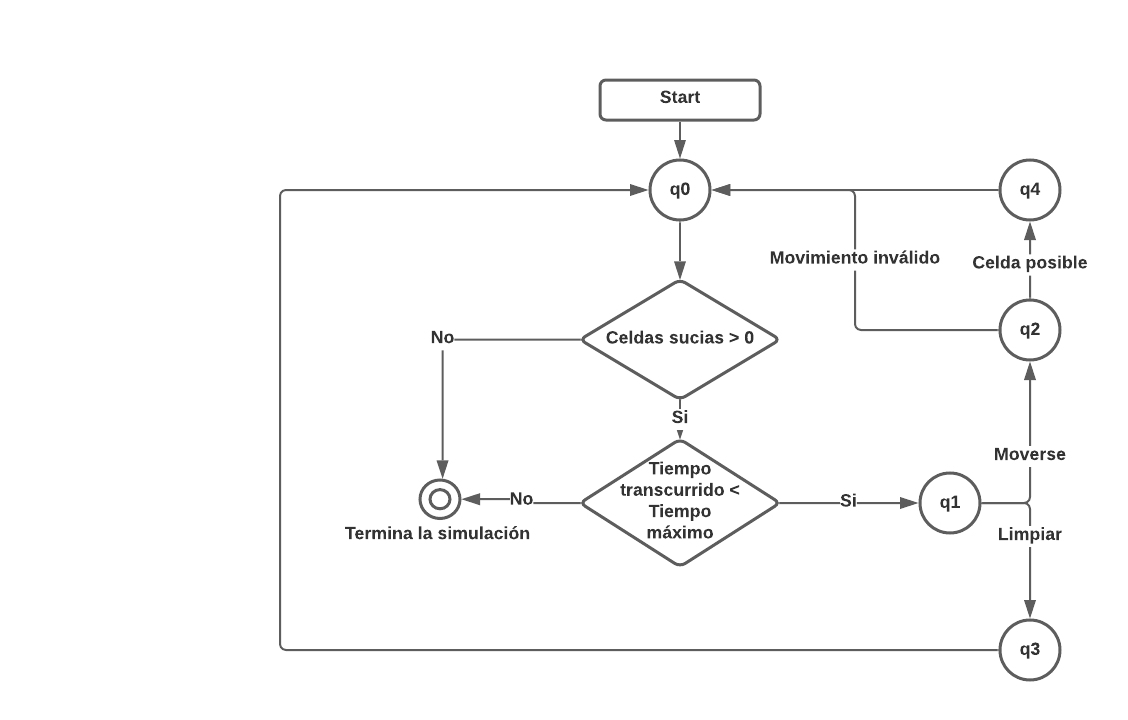